In [1]:
import sys
import os
sys.path.append('../')

from dataset.data import split_data
from question1 import eigen
from question2 import inc_pca

from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
from sklearn.neighbors import KNeighborsClassifier

1. Further divide the training data equally into four subsets, each with 104 images

In [7]:
data_path = "../dataset/face.mat"
train_data, train_label, test_data, test_label = split_data(data_path)

# 1. additional seperation of the training data
train_data1 = train_data[:, 0::4]
train_data2 = train_data[:, 1::4]
train_data3 = train_data[:, 2::4]
train_data4 = train_data[:, 3::4]

train_label1 = train_label[0::4]
train_label2 = train_label[1::4]
train_label3 = train_label[2::4]
train_label4 = train_label[3::4]

train_data = np.hstack([train_data1, train_data2, train_data3, train_data4])
train_label = np.concatenate([train_label1, train_label2, train_label3, train_label4])

2. Perform Incremental PCA, and compare it with the counterpart i.e. batch PCA, and PCA 
trained only by the first subset

    training time, reconstruction error, face recognition accuracy (using NN classification).   
    * time 측정 시 eigen-decomposition 제외 무시해도 됨 -> eigen-decomposition 부분에만 time을 달면 됨

In [44]:
# Incremental PCA: calculate batch time and memory, average of 10-time execution
total_time = []
batch_time = []
combine_time = []
memory_usage = []
n_components = 104
for i in range (10):
    ipca = inc_pca.IncrementalPCA(n_components=n_components, check_performance = True)
    eigvals, eigvecs = ipca.fit(train_data, 104)
    batch_time.append(ipca.new_batch_t)
    combine_time.append(ipca.combine_t)
    memory_usage.append(ipca.combine_m)

New batch eigen decomposition time: 0.07191 sec
[incremental_pca_eigen_decomposition] memory usage:  238.42969 MB
New batch eigen decomposition time: 0.04004 sec
[incremental_pca_eigen_decomposition] memory usage:  347.62891 MB
combined covariance matrix decomposition time: 0.14111 sec
[incremental_pca_eigen_decomposition] memory usage:  437.48828 MB
result shape:  (2576, 104) (104,)
New batch eigen decomposition time: 0.05685 sec
[incremental_pca_eigen_decomposition] memory usage:  380.83203 MB
combined covariance matrix decomposition time: 0.10104 sec
[incremental_pca_eigen_decomposition] memory usage:  437.61719 MB
result shape:  (2576, 104) (104,)
New batch eigen decomposition time: 0.03026 sec
[incremental_pca_eigen_decomposition] memory usage:  380.83203 MB
combined covariance matrix decomposition time: 0.07707 sec
[incremental_pca_eigen_decomposition] memory usage:  437.61719 MB
result shape:  (2576, 104) (104,)
New batch eigen decomposition time: 0.03468 sec
[incremental_pca_ei

In [45]:
print("time")
print(ipca.new_batch_t)
print(ipca.combine_t)
print("mem")
print(ipca.new_batch_m)
print(ipca.combine_m)

#print(ipca.eigenval)

time
[0.027202844619750977, 0.028512954711914062, 0.025949954986572266, 0.026098012924194336]
[0.0, 0.07341766357421875, 0.08179020881652832, 0.06569385528564453]
mem
[279.578125, 382.8828125, 382.8828125, 382.8828125]
[0.0, 439.66796875, 439.66796875, 439.66796875]


In [46]:
# average calculation: 여기서 total time이 training time으로 쓰일 수 있음
batch_time = np.array(batch_time)
combine_time = np.array(combine_time)
memory_usage = np.array(memory_usage)

batch_time_avg = batch_time.mean(axis=0)
combine_time_avg = combine_time[:, 1:].mean(axis=0)
combine_time_avg = np.concatenate(([0.0], combine_time_avg), axis=0)
total_time = batch_time_avg + combine_time_avg

memory_usage_avg = memory_usage.mean(axis=0)

print(batch_time_avg)
print(combine_time_avg)
print(total_time)
print(memory_usage_avg)

[0.039625   0.02924924 0.03207335 0.03610895]
[0.         0.0808789  0.07406759 0.07596288]
[0.039625   0.11012814 0.10614095 0.11207182]
[  0.         439.44804687 439.4609375  439.46132813]


-> how accurate your incremental method is, what important parameters in the method are???

In [53]:
mean_face = np.mean(train_data, axis=1).reshape(-1, 1)
val_batch, vec_batch = eigen.pca(train_data, mean_face)
print(val_batch[:5])

batch_size = 104

pca_time = []
pca_mem = []
for i in range (4):
    cur_train_data = train_data[:, :(i+1) * 104]
    cur_train_label = train_label[:(i+1) * 104]
    mean_face = np.mean(cur_train_data, axis=1).reshape(-1, 1)
    val_batch, vec_batch, t, m = eigen.pca_perf(cur_train_data, mean_face)
    pca_time.append(t)
    pca_mem.append(m)
print(pca_time)
print(pca_mem)

[895923.15478772 511687.42938117 447426.35962478 251955.73603765
 221668.83477448]
 0.03864 sec
[pca] memory usage:  290.55078 MB
 0.14610 sec
[pca] memory usage:  288.50391 MB
 0.49386 sec
[pca] memory usage:  294.63281 MB
 1.11727 sec
[pca] memory usage:  302.09375 MB
[0.03864169120788574, 0.1461021900177002, 0.49385762214660645, 1.1172659397125244]
[290.55078125, 288.50390625, 294.6328125, 302.09375]


In [54]:
# saving
# 결과 제대로 나왔을때만 키기
io.savemat('inc-batch-timemem-104.mat', {'inc_time':total_time, 'inc_batch_time': batch_time_avg,
                                     'inc_comb_time': combine_time_avg, 'inc_mem': memory_usage_avg,
                                     'batch_time': pca_time, 'batch_mem': pca_mem})


(4,) (4,)


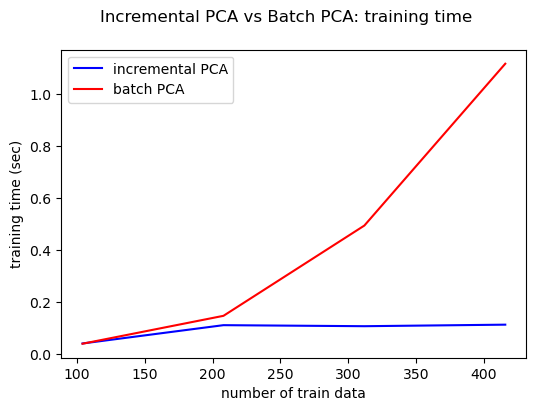

In [57]:
# 1. batch vs inc PCA, training time
base_dir = os.getcwd()  
full_data_path = os.path.join(base_dir, "./inc-batch-timemem-104.mat")
file = io.loadmat(full_data_path)
inc_time = np.array(file["inc_time"]).flatten()
inc_mem = np.array(file["inc_mem"]).flatten()
batch_time = np.array(file["batch_time"]).flatten()
batch_mem = np.array(file["batch_mem"]).flatten()

graph = plt.figure(figsize=(6, 4))
ax1 = graph.add_subplot(111)
#ax2 = graph.add_subplot(122)
X = np.arange(104, 417, 104)
print(X.shape, inc_time.shape)

ax1.plot(X, inc_time, color='b', label='incremental PCA')
ax1.plot(X, batch_time, color='r', label='batch PCA')
ax1.set_xlabel('number of train data')
ax1.set_ylabel('training time (sec)')
ax1.legend()

#ax2.plot(X, inc_mem, color='b', label='incremental PCA')
#ax2.plot(X, batch_mem, color='r', label='batch PCA')
#ax2.set_xlabel('number of train data')
#ax2.set_ylabel('memory usage (MB)')

plt.suptitle('Incremental PCA vs Batch PCA: training time')
# 결과 제대로 나왔을때만 키기
plt.savefig('q2-fig1-1', dpi=300)

In [66]:
# ------------------------
# 여기 아래로 실험은 이거만 돌리면 다 가능함, 2, 3, 4 실험을 위한 기본 데이터 뽑는 과정

pca_mean = []
pca_eigenvec = []
pca_eigenval = []
for i in range (4):
    cur_train_data = train_data[:, :(i+1) * 104]
    cur_train_label = train_label[:(i+1) * 104]
    mean_face = np.mean(cur_train_data, axis=1).reshape(-1, 1)
    val_batch, vec_batch = eigen.pca(cur_train_data, mean_face)
    pca_mean.append(mean_face)
    pca_eigenvec.append(vec_batch)
    pca_eigenval.append(val_batch)

ipca = inc_pca.IncrementalPCA(n_components=50, step_save=True)
eigvals, eigvecs = ipca.fit(train_data, 104)

result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)


[1. 1. 1. 1.] [1.         0.90095859 0.89137504 0.8561277 ] [1.         0.99999556 0.99999034 0.99998515]


Text(0.5, 0.98, 'Incremental PCA vs Batch PCA:\ncosine similarity between results')

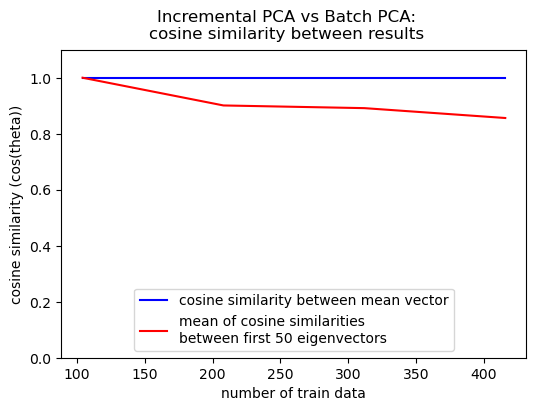

In [67]:
# 2. batch vs inc PCA, eigenvector/mean cosine similarity by first 50 components
#idx 0, 1, 2, 3에 각각 104, 208, 312, 416 train data에서 similarity가 들어감
from sklearn.metrics.pairwise import cosine_similarity

mean_similarity = []
vec_similarity = []
val_similarity = []
for i in range (4):
    cur_batch_mean = pca_mean[i]
    cur_batch_vec = pca_eigenvec[i][:,:50]
    cur_batch_val = pca_eigenval[i][:50].reshape(-1, 1)
    cur_inc_mean = ipca.step_mean[i]
    cur_inc_vec = ipca.step_eigenvec[i]
    cur_inc_val = ipca.step_eigenval[i].reshape(-1, 1)

    mean_similarity.append(cosine_similarity(cur_batch_mean.T, cur_inc_mean.T))
    vec_similarity.append(np.diag(cosine_similarity(cur_batch_vec.T, cur_inc_vec.T)))
    val_similarity.append(cosine_similarity(cur_batch_val.T, cur_inc_val.T))

mean_similarity = np.array(mean_similarity).flatten()
vec_similarity = abs(np.array(vec_similarity)).mean(axis=1)
val_similarity = np.array(val_similarity).flatten()

# 1, 2, 3, 4 batch에서 mean / eigenvector cosine similarity
print(mean_similarity, vec_similarity, val_similarity)

# draw graph
graph = plt.figure(figsize=(6, 4))
ax1 = graph.add_subplot(111)
X = np.arange(104, 417, 104)
ax1.set_ylim([0.0, 1.1])

ax1.plot(X, mean_similarity, color='b', label='cosine similarity between mean vector')
ax1.plot(X, vec_similarity, color='r', label='mean of cosine similarities\nbetween first 50 eigenvectors')
#ax1.plot(X, val_similarity, color='g', label='cosine similarities between first 50 eigenvalues')

ax1.set_xlabel('number of train data')
ax1.set_ylabel('cosine similarity (cos(theta))')
ax1.legend(loc='lower center')

plt.suptitle('Incremental PCA vs Batch PCA:\ncosine similarity between results')
#plt.savefig('q2-fig2', dpi=300)

In [9]:
# 3. batch vs inc PCA, reconstruction error by first 50 components
M = 50

mean_face = np.mean(train_data, axis=1).reshape(-1, 1)
val_batch, vec_batch = eigen.pca(train_data, mean_face)

ipca = inc_pca.IncrementalPCA(n_components=M, step_save=True)
eigvals, eigvecs = ipca.fit(train_data, 104)

theoretical_error = []
batch_error = []
inc_error = np.zeros((4, M))
for i in range (1, M+1):
    th, bh = eigen.face_reconstruction(test_data, val_batch, vec_batch, mean_face, M = i)
    theoretical_error.append(th)
    batch_error.append(bh)

    for j in range (0, 4):
        _, inc = eigen.face_reconstruction(test_data, ipca.step_eigenval[j], ipca.step_eigenvec[j], ipca.step_mean[j], M = i)
        inc_error[j][i-1] = inc

result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)


(50,)
(50,)
(50,)
(50,)


Text(0.5, 1.0, 'Test data reconstruction error according to the number of PCA bases')

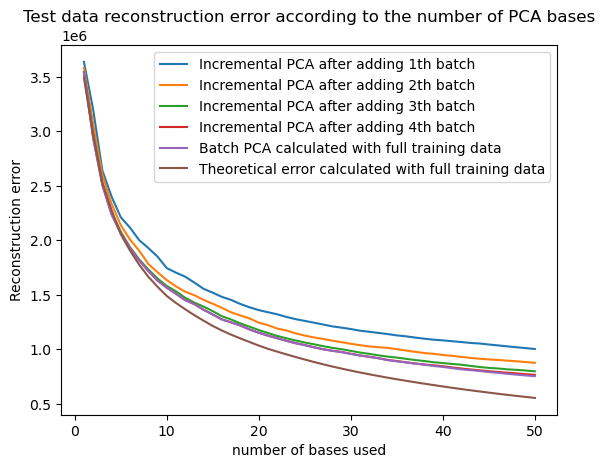

In [56]:
# problem3: draw graph
graph = plt.figure()
ax1 = graph.add_subplot(111)
X = np.arange(1, M+1)

for j in range (0,4):
    print(inc_error[j].shape)
    ax1.plot(X, inc_error[j], label="Incremental PCA after adding {}th batch".format(j+1))

ax1.plot(X, batch_error, label='Batch PCA calculated with full training data')
ax1.plot(X, theoretical_error, label='Theoretical error calculated with full training data')

ax1.set_ylabel('Reconstruction error')
ax1.set_xlabel('number of bases used')

plt.legend()
plt.title('Test data reconstruction error according to the number of PCA bases')

In [41]:
# 4. batch vs inc PCA, KNN classification accuracy by first 50 components
n_neighbors = 1
M = 100

batch_knn = []
inc_knn = np.zeros((4, M))
for i in range (1, M+1):
    train_PCA_data = eigen.pca_transform(train_data, val_batch, vec_batch, mean_face, M = i)
    test_PCA_data = eigen.pca_transform(test_data, val_batch, vec_batch, mean_face, M = i)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
    model.fit(train_PCA_data.T, train_label)
    batch_knn.append(model.score(test_PCA_data.T, test_label))

    for j in range (0, 4):
        train_PCA_data = eigen.pca_transform(train_data, ipca.step_eigenval[j], ipca.step_eigenvec[j], ipca.step_mean[j], M = i)
        test_PCA_data = eigen.pca_transform(test_data, ipca.step_eigenval[j], ipca.step_eigenvec[j], ipca.step_mean[j], M = i)

        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
        model.fit(train_PCA_data.T, train_label)
        inc_knn[j][i-1] = model.score(test_PCA_data.T, test_label)

Text(0.5, 1.0, 'KNN classification accuracy according to the number of PCA bases')

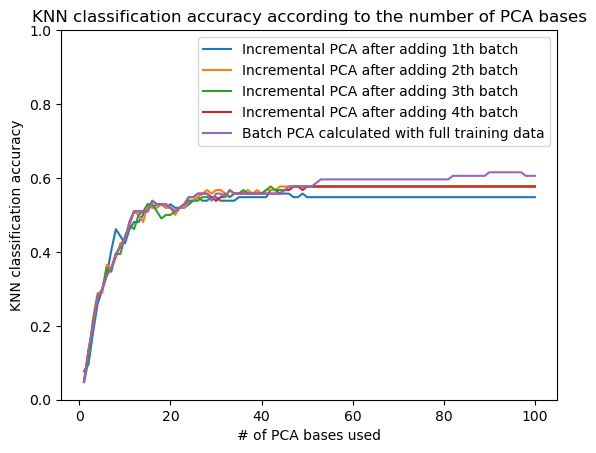

In [42]:
# problem4: draw graph
graph = plt.figure()
ax1 = graph.add_subplot(111)
ax1.set_ylim([0.0, 1.0])
X = np.arange(1, M+1)

for j in range (0,4):
    ax1.plot(X, inc_knn[j], label="Incremental PCA after adding {}th batch".format(j+1))
ax1.set_ylabel('KNN classification accuracy')
ax1.set_xlabel('# of PCA bases used')

ax1.plot(X, batch_knn, label='Batch PCA calculated with full training data')

plt.legend()
plt.title('KNN classification accuracy according to the number of PCA bases')

Text(0.5, 1.0, 'KNN classification accuracy according to the number of PCA bases')

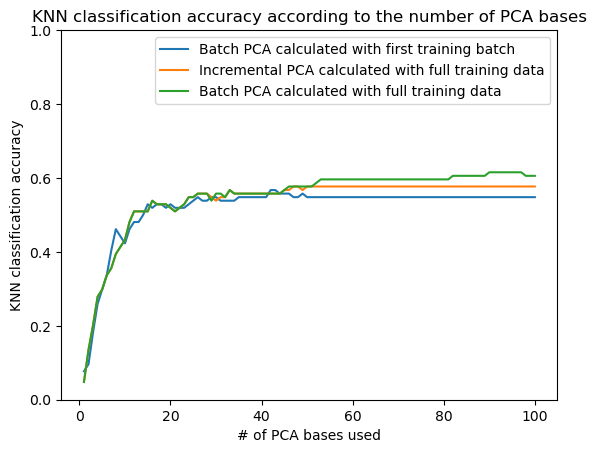

In [43]:
# problem4: draw graph -> simple ver
graph = plt.figure()
ax1 = graph.add_subplot(111)
ax1.set_ylim([0.0, 1.0])
X = np.arange(1, M+1)

ax1.plot(X, inc_knn[0], label="Batch PCA calculated with first training batch")
ax1.plot(X, inc_knn[3], label="Incremental PCA calculated with full training data")
ax1.set_ylabel('KNN classification accuracy')
ax1.set_xlabel('# of PCA bases used')

ax1.plot(X, batch_knn, label='Batch PCA calculated with full training data')

plt.legend()
plt.title('KNN classification accuracy according to the number of PCA bases')

In [104]:
# important parameter: d3 testing -> tradeoff btw accuracy-time
mean_face = np.mean(train_data, axis=1).reshape(-1, 1)
val_batch, vec_batch = eigen.pca(train_data, mean_face)

total_time = []
batch_time = []
combine_time = []
memory_usage = []
vec_similarity = []
min = 30
for i in range (min, 105, 10):
    temp_batch = 0.0
    temp_combine = 0.0
    for j in range (10):
        ipca = inc_pca.IncrementalPCA(n_components=i, check_performance = True)
        eigvals, eigvecs = ipca.fit(train_data, 104)
        temp_batch += sum(ipca.new_batch_t)
        temp_combine += sum(ipca.combine_t)
    batch_time.append(temp_batch / 10.0)
    combine_time.append(temp_combine / 10.0)

    vec_similarity.append(abs(np.diag(cosine_similarity(vec_batch.T[:min, :], eigvecs.T[:min, :]))).mean())

#vec_similarity = abs(np.array(vec_similarity)).mean(axis=1)
print(np.array(vec_similarity))
print(batch_time)
print(combine_time)



New batch eigen decomposition time: 0.02166 sec
[incremental_pca_eigen_decomposition] memory usage:  355.43750 MB
New batch eigen decomposition time: 0.02152 sec
[incremental_pca_eigen_decomposition] memory usage:  458.74219 MB
combined covariance matrix decomposition time: 0.00912 sec
[incremental_pca_eigen_decomposition] memory usage:  510.57031 MB
result shape:  (2576, 30) (30,)
New batch eigen decomposition time: 0.02608 sec
[incremental_pca_eigen_decomposition] memory usage:  456.69531 MB
combined covariance matrix decomposition time: 0.00944 sec
[incremental_pca_eigen_decomposition] memory usage:  508.52344 MB
result shape:  (2576, 30) (30,)
New batch eigen decomposition time: 0.01901 sec
[incremental_pca_eigen_decomposition] memory usage:  456.69531 MB
combined covariance matrix decomposition time: 0.00703 sec
[incremental_pca_eigen_decomposition] memory usage:  508.52344 MB
result shape:  (2576, 30) (30,)
New batch eigen decomposition time: 0.02203 sec
[incremental_pca_eigen_de

In [105]:
# saving
# 결과 제대로 나왔을때만 키기
io.savemat('inc-tradeoff.mat', {'vec_similarity':vec_similarity, 'batch_time': batch_time, 'combine_time': combine_time})

(8,) (4,)


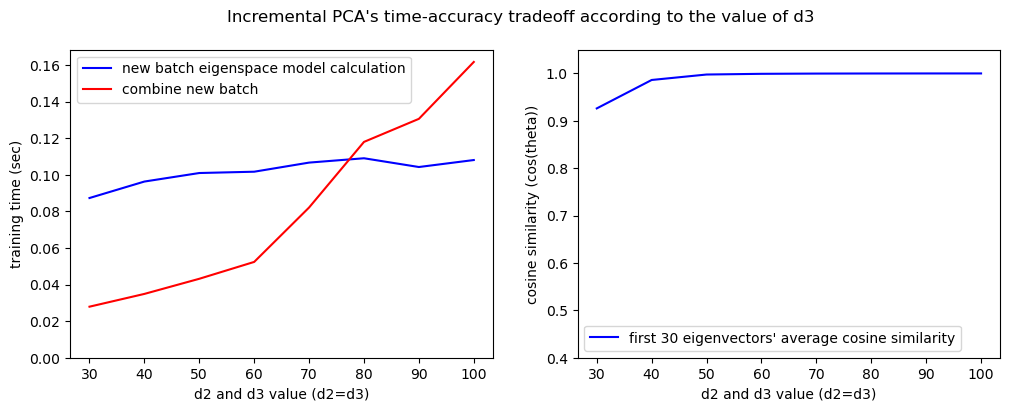

In [107]:
# important parameter: d3 testing -> draw graph
base_dir = os.getcwd()  
full_data_path = os.path.join(base_dir, "./inc-tradeoff.mat")
file = io.loadmat(full_data_path)
vec_similarity = np.array(file["vec_similarity"]).flatten()
batch_time = np.array(file["batch_time"]).flatten()
combine_time = np.array(file["combine_time"]).flatten()

graph = plt.figure(figsize=(12, 4))
ax1 = graph.add_subplot(121)
ax2 = graph.add_subplot(122)
X = np.arange(min, 105, 10)
print(X.shape, inc_time.shape)

ax1.plot(X, batch_time, color='b', label='new batch eigenspace model calculation')
ax1.plot(X, combine_time, color='r', label='combine new batch')
ax1.set_xlabel('d2 and d3 value (d2=d3)')
ax1.set_ylabel('training time (sec)')
ax1.legend()
ax1.set_ylim(0.0, )

ax2.plot(X, vec_similarity, color='b', label='first {} eigenvectors\' average cosine similarity'.format(min))
ax2.set_xlabel('d2 and d3 value (d2=d3)')
ax2.set_ylabel('cosine similarity (cos(theta))')
ax2.set_ylim(0.4, 1.05)
ax2.legend()

plt.suptitle('Incremental PCA\'s time-accuracy tradeoff according to the value of d3')
# 결과 제대로 나왔을때만 키기
plt.savefig('q2-fig5', dpi=300)

In [61]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload